<a href="https://colab.research.google.com/github/eliseleahy/Pytorch-Tutorials/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow. 

In [263]:
What_were_covering = {1: "data (prepare and load)", 
                      2: "building model", 
                      3: "fitting the model to data (training)", 
                      4: "making predictions and evaluting a model (inference)", 
                      5: "saving and loading a model", 
                      6: "putting it all together"
                      }

What_were_covering

{1: 'data (prepare and load)',
 2: 'building model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [264]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

## 1. Data (preparing and loading)

Data can be almost anything in machine learning. 
* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. get data into a numerical representation
2. build a model to learn patterns in that numerical representation

To showcase this, lets create some *known* data using the linear regression forumla. 


In [265]:
#Create *Known* parameters
weight = 0.7
bias = 0.3

# create 
start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1) #unsqueeze adds extra dimension
y=weight*X +bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]), 50, 50)

### Splitting data into training and test sets (!IMPORTANT!)

Lets create a traing and test set with out data. 

In [266]:
# Create train/test split
train_split=int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualise our data!

In [267]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train, 
                     test_data=X_test,
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  #Are there predictions
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  #Show legend
  plt.legend(prop={"size":14});


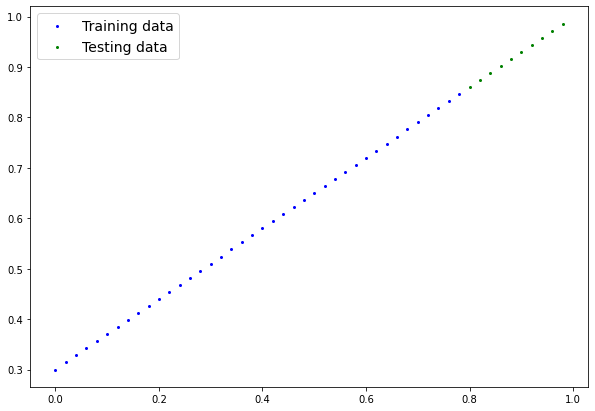

In [268]:
plot_predictions();

## 2. Building Model

Our first pytorch model

What our model does:
* Start with rnadom values (weight and bias)
* Look at training data and adjust the random values to better represent the ideal values

How? 

Through two main algoritms: 
1. Gradient descent
2. Backpropogation

In [269]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): #<- everything from pytorch inherits from nn.modules 
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, 
                                            requires_grad=True, 
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True, 
                                            dtype=torch.float))
    
  #Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #<- y
    return self.weights *x + self.bias


## PyTorch Model building essentials 

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these. 
* torch.nn.Module - the base class for all nueal network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers live and will help with gradient descent 
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Can check whats inside model using .paramters()

In [270]:
#Create random seed

torch.manual_seed(42)

#Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

#Check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [271]:
# List name paramters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using 'torch.inference_mode()'

To check our models's predictive power, lets see how well it predicts y test and x test

When we pass data through our model it will run it through our forward model



In [272]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [273]:
# Make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad inference mode is pereferred
#with torch.no_grad():
#  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

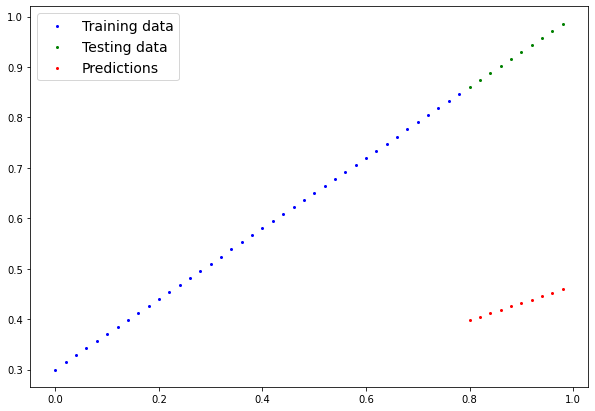

In [274]:
plot_predictions(predictions=y_preds)

## 3. Train model

One way to measure how poor or how wring the models predictions are is to use a loss function 

* note: loss function may also be called cost function or criterion in our case we will refer to it as a loss function 

Things we need to train:

* **Loss function:** A function to measure how winr your models predictions are compared to your models output -> lower is better
* **Optimiser:** takes into account the loss of a model and adjusts the models paraters (e.g. weight and bias) to imporve the loss function 

And specically for PyTorch we need a:
* a training loop
* a testing loop


In [275]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [276]:
abs(y_preds[0]-y_test[0])

tensor([0.4618])

In [277]:
# Set up a loss function 
loss_fn = nn.L1Loss()

# Set up an optimiser (sgd - stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(), 
                            lr =0.01) # lr = leanring rate = most important hyper parameters



### Building a Training and Testing Loop

Things needed in a training loop:
0. Loop through the data
1. Forward pass (This involves data moveing through our models forward() functions (also called forward propogations)
2. Calculate loss
3. Optiser zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each pf the paremters with repsect to loss (**back propogation**)
5. Optimiser step - use optimiser to adjust model paramters to reduce loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)

#from torch.optim import optimizer
# An epoch is one loop through the data.... (hyper paramter as we've set it ourselves)
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

## Training 
# 0. loop through the data 
for epoch in range(epochs):
  # Set the model to training model
  model_0.train() # train mode in OyTorch sets all paremters that require gardients to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calulate loss
  loss = loss_fn(y_pred, y_train)
  #print(loss)

  # 3. Optimiser zero grad
  optimizer.zero_grad()

  # 4. Perform backward propogation on loss to paramter of the model
  loss.backward()

  # 5. Step the optimiser (perform gradient descent)
  optimizer.step() # by defluat tell the optimiser changes will accumlate through the loop so.. we ahve to change them to zero in step 3

  model_0.eval() # turns off gradient tracker

  ###Testing 
  model_0.eval() #turns off the different settings in the model not need for evaluation/testing. (drop out/batch norm)
  with torch.inference_mode(): # turns off gradient tracking and some other things behind the scenes. 
    #1. Forward pass
    test_pred = model_0(X_test)

    # 2. calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())


Text(0.5, 0, 'epoch')

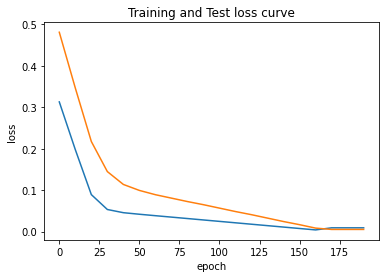

In [279]:
import numpy as np
train_loss_values = np.array(torch.tensor(train_loss_values).numpy())

# plot loss curves

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test loss curve")
plt.ylabel("loss")
plt.xlabel("epoch")

In [280]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [281]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [282]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

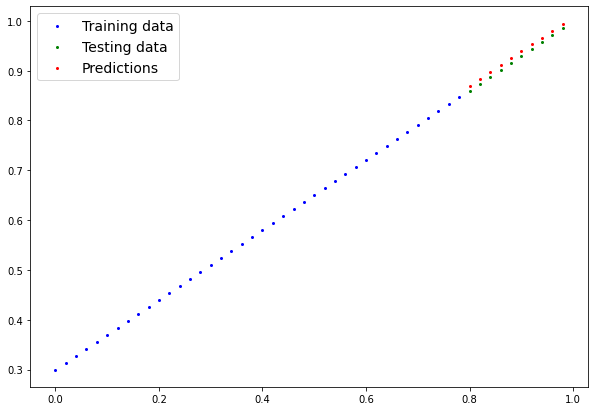

In [283]:
plot_predictions(predictions=y_preds_new)